In [1]:
import pandas as pd
import json
import requests
import time
import numpy as np
from functools import reduce
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pickle

## Introduction

The purpose of this notebook is to show the steps for data prepration for the prediction task.

## Data Collection
We get our raw data from Alpha Vantage APIs as it's refined and free of cost.
The data is got in form of JSON object which is stored as a pandas dataframe in a dictionary with symbol name as the key

In [2]:
# commonly used variables

symbol = "AAPL";
apikey = "V1SZPLE0U8CCXSFW.";
datatype = "json";
url = "https://www.alphavantage.co/query";
outputsize = "full";
interval = "daily";
timeperiod = "10";
seriestype = "close";
index = "date";
plt.style.use('seaborn');

In [16]:
# Time Series Data

parameters = {'function':'TIME_SERIES_DAILY_ADJUSTED', 'outputsize':outputsize,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_TS_data = pd.DataFrame(data["Time Series (Daily)"]).T

AAPL_TS_data.reset_index(inplace=True);
AAPL_TS_data.rename(columns={'index': 'date'}, inplace=True);

AAPL_TS_data.rename(columns={'1. open': 'open'}, inplace=True);
AAPL_TS_data.rename(columns={'2. high': 'high'}, inplace=True);
AAPL_TS_data.rename(columns={'3. low': 'low'}, inplace=True);
AAPL_TS_data.rename(columns={'4. close': 'close'}, inplace=True);
AAPL_TS_data.rename(columns={'5. adjusted close': 'adjusted close'}, inplace=True);
AAPL_TS_data.rename(columns={'6. volume': 'volume'}, inplace=True);
AAPL_TS_data.rename(columns={'7. dividend amount': 'dividend amount'}, inplace=True);
AAPL_TS_data.rename(columns={'8. split coefficient': 'split coefficient'}, inplace=True);

# Let's add another column to the frame which is the adjusted close data shifted by 10 days which is what we want to predict

AAPL_TS_data["Target"] = AAPL_TS_data["adjusted close"].shift(-10);

# Now that we donot have the data of the future we need to clip the dataframe where the target is not defined 
AAPL_TS_data = AAPL_TS_data.dropna()


display(AAPL_TS_data.tail())
display(AAPL_TS_data.info())

,date,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Target
5240,2018-10-29,219.1900,219.6900,206.0900,212.2400,211.4995,45935520,0.0000,1.0000,194.1700
5241,2018-10-30,211.1500,215.1800,209.2700,213.3000,212.5558,36659990,0.0000,1.0000,192.2300
5242,2018-10-31,216.8800,220.4500,216.6200,218.8600,218.0964,38358933,0.0000,1.0000,186.8000
5243,2018-11-01,219.0500,222.3600,216.8100,222.2200,221.4446,58323180,0.0000,1.0000,191.4100
5244,2018-11-02,209.5500,213.6500,205.4300,207.4800,206.7561,91328654,0.0000,1.0000,193.5300


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5244
Data columns (total 10 columns):
date                 5245 non-null object
open                 5245 non-null object
high                 5245 non-null object
low                  5245 non-null object
close                5245 non-null object
adjusted close       5245 non-null object
volume               5245 non-null object
dividend amount      5245 non-null object
split coefficient    5245 non-null object
Target               5245 non-null object
dtypes: object(10)
memory usage: 450.7+ KB


None

In [4]:
#Let's plot the time series data and see what that looks like
#Athough first we will have to convert the data into matplot readable format
#Thus we won't play with actual data but make a copy of it.

AAPL_TS_plotdata = AAPL_TS_data;
AAPL_TS_plotdata['open'] = pd.to_numeric(AAPL_TS_plotdata['open']);
AAPL_TS_plotdata['high'] = pd.to_numeric(AAPL_TS_plotdata['high']);
AAPL_TS_plotdata['low'] = pd.to_numeric(AAPL_TS_plotdata['low']);
AAPL_TS_plotdata['close'] = pd.to_numeric(AAPL_TS_plotdata['close']);
AAPL_TS_plotdata['adjusted close'] = pd.to_numeric(AAPL_TS_plotdata['adjusted close']);
AAPL_TS_plotdata['volume'] = pd.to_numeric(AAPL_TS_plotdata['volume']);
AAPL_TS_plotdata['dividend amount'] = pd.to_numeric(AAPL_TS_plotdata['dividend amount']);
AAPL_TS_plotdata['split coefficient'] = pd.to_numeric(AAPL_TS_plotdata['split coefficient']);
AAPL_TS_plotdata['Target'] = pd.to_numeric(AAPL_TS_plotdata['Target']);

AAPL_TS_plotdata['date']=pd.to_datetime(AAPL_TS_plotdata['date']);
AAPL_TS_plotdata['date'] = AAPL_TS_plotdata['date'].astype(dt.datetime);
AAPL_TS_plotdata = AAPL_TS_plotdata.set_index('date');

#AAPL_TS_plotdata = AAPL_TS_plotdata.drop(['volume','dividend amount','split coefficient','open','high','Target','low'], axis=1);

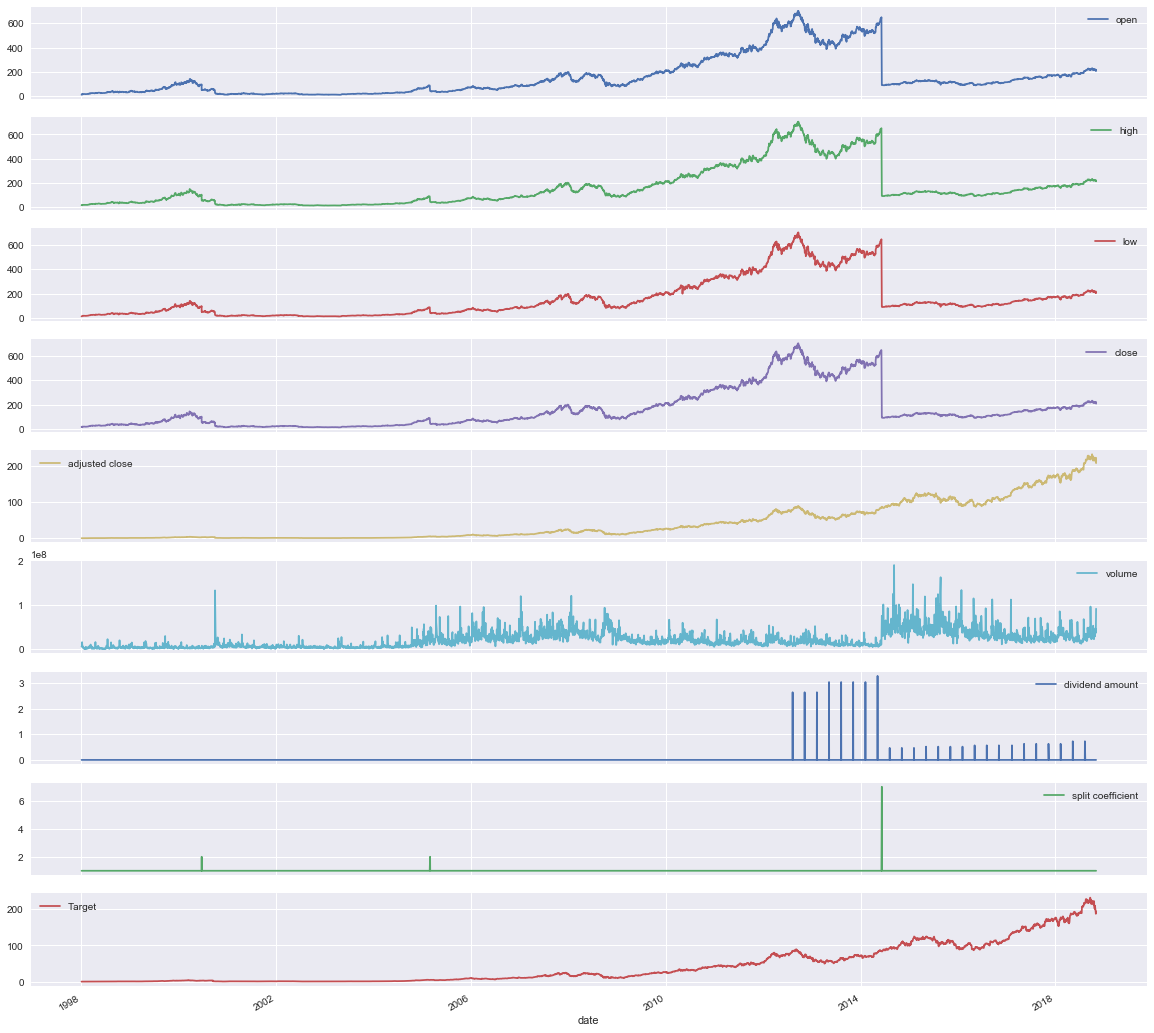

In [5]:
AAPL_TS_plotdata.plot(kind='line', subplots=True, grid=True,figsize=(20, 20));

In [17]:
#ADX Data

parameters = {'function':'ADX', 'interval':interval,'time_period':timeperiod,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_ADX_data = pd.DataFrame(data["Technical Analysis: ADX"]).T

AAPL_ADX_data.reset_index(inplace=True);
AAPL_ADX_data.rename(columns={'index': 'date'}, inplace=True);


display(AAPL_ADX_data.head())
display(AAPL_ADX_data.info())

,date,ADX
0,1998-01-30,50.0186
1,1998-02-02,45.0540
2,1998-02-03,40.8746
3,1998-02-04,37.1132
4,1998-02-05,33.7280


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5236 entries, 0 to 5235
Data columns (total 2 columns):
date    5236 non-null object
ADX     5236 non-null object
dtypes: object(2)
memory usage: 81.9+ KB


None

In [7]:
#Let's visualize this data and see what it looks like

AAPL_ADX_plotdata = AAPL_ADX_data;
AAPL_ADX_plotdata['date']=pd.to_datetime(AAPL_ADX_plotdata['date']);
AAPL_ADX_plotdata['ADX'] = pd.to_numeric(AAPL_ADX_plotdata['ADX']);
AAPL_ADX_plotdata['date'] = AAPL_ADX_plotdata['date'].astype(dt.datetime);
AAPL_ADX_plotdata = AAPL_ADX_plotdata.set_index('date');

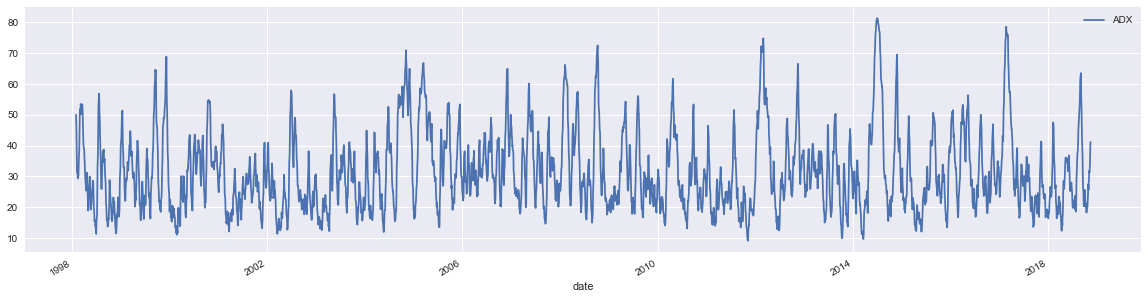

In [8]:
AAPL_ADX_plotdata.plot(subplots=True, figsize=(20, 5));

In [18]:
#RSI Data

parameters = {'function':'RSI', 'interval':interval,'time_period':timeperiod,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_RSI_data = pd.DataFrame(data["Technical Analysis: RSI"]).T

AAPL_RSI_data.reset_index(inplace=True);
AAPL_RSI_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_RSI_data.head())
display(AAPL_RSI_data.info())

,date,RSI
0,1998-01-16,65.8809
1,1998-01-20,67.0176
2,1998-01-21,65.5614
3,1998-01-22,67.3482
4,1998-01-23,68.6760


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 2 columns):
date    5245 non-null object
RSI     5245 non-null object
dtypes: object(2)
memory usage: 82.0+ KB


None

In [19]:
#SMA_data

parameters = {'function':'SMA', 'interval':interval,'time_period':timeperiod,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_SMA_data = pd.DataFrame(data["Technical Analysis: SMA"]).T
AAPL_SMA_data.reset_index(inplace=True);
AAPL_SMA_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_SMA_data.head())
display(AAPL_SMA_data.info())

,date,SMA
0,1998-01-15,18.1640
1,1998-01-16,18.4200
2,1998-01-20,18.7380
3,1998-01-21,18.7350
4,1998-01-22,18.9100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5246 entries, 0 to 5245
Data columns (total 2 columns):
date    5246 non-null object
SMA     5246 non-null object
dtypes: object(2)
memory usage: 82.0+ KB


None

In [20]:
# MACD_data

parameters = {'function':'MACD', 'interval':interval,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_MACD_data = pd.DataFrame(data["Technical Analysis: MACD"]).T

AAPL_MACD_data.reset_index(inplace=True);
AAPL_MACD_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_MACD_data.head())
display(AAPL_MACD_data.info())

,date,MACD,MACD_Hist,MACD_Signal
0,1998-02-20,0.4518,0.1604,0.2913
1,1998-02-23,0.5519,0.2084,0.3435
2,1998-02-24,0.6289,0.2283,0.4005
3,1998-02-25,0.7617,0.2890,0.4728
4,1998-02-26,0.9521,0.3835,0.5686


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5222 entries, 0 to 5221
Data columns (total 4 columns):
date           5222 non-null object
MACD           5222 non-null object
MACD_Hist      5222 non-null object
MACD_Signal    5222 non-null object
dtypes: object(4)
memory usage: 163.3+ KB


None

## Structuring the data
Now that we have all the data we can start with the preprocessing of the same.
let's define the fields that we are interested in.

we need below details for every stock

+ simple moving average
+ ADX
+ RSI
+ MACD
+ volume
+ high
+ low
+ adjusted close

And having all this info we would be predicting what the price would be 10 days down the line.

#### Let's first create the single data frame and split that into Train, Test and Validation data.

In [21]:
display(AAPL_ADX_data.info())
display(AAPL_TS_data.info())
display(AAPL_SMA_data.info())
display(AAPL_RSI_data.info())
display(AAPL_MACD_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5236 entries, 0 to 5235
Data columns (total 2 columns):
date    5236 non-null object
ADX     5236 non-null object
dtypes: object(2)
memory usage: 81.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5244
Data columns (total 10 columns):
date                 5245 non-null object
open                 5245 non-null object
high                 5245 non-null object
low                  5245 non-null object
close                5245 non-null object
adjusted close       5245 non-null object
volume               5245 non-null object
dividend amount      5245 non-null object
split coefficient    5245 non-null object
Target               5245 non-null object
dtypes: object(10)
memory usage: 450.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5246 entries, 0 to 5245
Data columns (total 2 columns):
date    5246 non-null object
SMA     5246 non-null object
dtypes: object(2)
memory usage: 82.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 2 columns):
date    5245 non-null object
RSI     5245 non-null object
dtypes: object(2)
memory usage: 82.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5222 entries, 0 to 5221
Data columns (total 4 columns):
date           5222 non-null object
MACD           5222 non-null object
MACD_Hist      5222 non-null object
MACD_Signal    5222 non-null object
dtypes: object(4)
memory usage: 163.3+ KB


None

In [22]:
All_frames = [AAPL_ADX_data,AAPL_SMA_data,AAPL_RSI_data,AAPL_MACD_data,AAPL_TS_data];

# Luckily this cool function reduces the final merged dataframe dropping any of the rows where the values were not present.
# Thus we get a clean dataframe to use which is fully cleaned.

Merged_frames = reduce(lambda  left,right: pd.merge(left,right), All_frames)

display(Merged_frames.head())
display(Merged_frames.info())

,date,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Target
0,1998-02-20,35.8066,19.5620,62.2914,0.4518,0.1604,0.2913,20.5000,20.5600,19.8100,20.0000,0.6308,2905500,0.0000,1.0000,0.7708
1,1998-02-23,38.2897,19.8370,72.2154,0.5519,0.2084,0.3435,20.1200,21.6200,20.0000,21.2500,0.6702,4263300,0.0000,1.0000,0.7175
2,1998-02-24,40.5245,20.0490,72.6000,0.6289,0.2283,0.4005,21.3100,21.3700,20.7500,21.3100,0.6721,4076700,0.0000,1.0000,0.7588
3,1998-02-25,43.7290,20.3360,78.1904,0.7617,0.2890,0.4728,21.3100,22.7500,20.9400,22.3100,0.7037,6363100,0.0000,1.0000,0.8238
4,1998-02-26,47.0657,20.7860,82.8240,0.9521,0.3835,0.5686,22.3100,23.5600,21.8700,23.5000,0.7412,5313700,0.0000,1.0000,0.8516


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5212 entries, 0 to 5211
Data columns (total 16 columns):
date                 5212 non-null object
ADX                  5212 non-null object
SMA                  5212 non-null object
RSI                  5212 non-null object
MACD                 5212 non-null object
MACD_Hist            5212 non-null object
MACD_Signal          5212 non-null object
open                 5212 non-null object
high                 5212 non-null object
low                  5212 non-null object
close                5212 non-null object
adjusted close       5212 non-null object
volume               5212 non-null object
dividend amount      5212 non-null object
split coefficient    5212 non-null object
Target               5212 non-null object
dtypes: object(16)
memory usage: 692.2+ KB


None

In [23]:
# And now for the final touch and creating the Training, Validation and Test sets

total_length = Merged_frames.shape[0];

Train_set = Merged_frames.iloc[:5000];
Validation_set = Merged_frames.iloc[5000:5100];
Test_set = Merged_frames.iloc[5100:total_length];

In [24]:
## Training Data and Labels

## pre processing the data
Train_set_morphed = Train_set.drop(['date'], axis=1);
train_names = Train_set_morphed.columns;
train_set_scaler = preprocessing.StandardScaler();
Train_set_scaled = train_set_scaler.fit_transform(Train_set_morphed);
Train_set_scaled = pd.DataFrame(Train_set_scaled, columns=train_names);


Train_labels_scaled = Train_set_scaled[['Target']].copy();
Train_labels_scaled = Train_labels_scaled.astype('float64');
Train_data_scaled = Train_set_scaled.drop(['Target'], axis=1)

display(Train_labels_scaled.tail());
display(Train_data_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Target
4995,3.024360
4996,3.046337
4997,3.086515
4998,3.066536
4999,3.131133


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
0,0.322917,-0.840074,0.527350,0.024826,0.053747,0.008684,-0.833204,-0.836981,-0.833443,-0.836490,-0.829775,-0.982158,-0.051427,-0.018356
1,0.513779,-0.838401,1.166106,0.035262,0.069881,0.014486,-0.835510,-0.830598,-0.832279,-0.828897,-0.828879,-0.907823,-0.051427,-0.018356
2,0.685556,-0.837110,1.190860,0.043290,0.076570,0.020822,-0.828288,-0.832103,-0.827683,-0.828533,-0.828836,-0.918038,-0.051427,-0.018356
3,0.931868,-0.835364,1.550685,0.057135,0.096973,0.028859,-0.828288,-0.823793,-0.826518,-0.822459,-0.828118,-0.792866,-0.051427,-0.018356
4,1.188341,-0.832625,1.848925,0.076985,0.128738,0.039507,-0.822218,-0.818916,-0.820819,-0.815232,-0.827266,-0.850317,-0.051427,-0.018356


In [25]:
## Validation data and labels

## pre processing the data
Validation_set_morphed = Validation_set.drop(['date'], axis=1);
validation_names = Validation_set_morphed.columns;
validation_set_scaler = preprocessing.StandardScaler();
Validation_set_scaled = validation_set_scaler.fit_transform(Validation_set_morphed);
Validation_set_scaled = pd.DataFrame(Validation_set_scaled, columns=validation_names);


Validation_labels_scaled = Validation_set_scaled[['Target']].copy();
Validation_labels_scaled = Validation_labels_scaled.astype('float64');
Validation_data_scaled = Validation_set_scaled.drop(['Target'], axis=1);


display(Validation_labels_scaled.head());
display(Validation_data_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Target
0,0.282338
1,0.200514
2,0.051164
3,0.055254
4,-0.233200


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
0,-1.052789,-0.155788,-0.153397,-0.086175,-0.485662,0.199194,-0.202802,-0.182719,-0.074027,-0.243822,-0.309974,-0.416318,-0.142465,0.0
1,-1.102008,-0.180237,0.063190,-0.063443,-0.374794,0.157701,-0.201531,-0.329149,-0.059614,-0.143520,-0.212629,-0.925183,-0.142465,0.0
2,-0.993046,-0.169713,0.534683,0.023149,-0.182401,0.147063,-0.087097,-0.071540,0.056894,0.103474,0.027077,-0.863208,-0.142465,0.0
3,-0.876966,-0.180399,0.317087,0.064411,-0.102161,0.149237,0.028608,-0.039000,0.162591,0.021979,-0.052014,-1.085140,-0.142465,0.0
4,-0.842889,-0.191410,0.310046,0.092387,-0.059519,0.158288,0.054038,-0.113571,0.100134,0.019471,-0.054447,-0.998239,-0.142465,0.0


In [26]:
## Test data and labels

## pre processing the data
Test_set_morphed = Test_set.drop(['date'], axis=1);
test_names = Test_set_morphed.columns;
test_set_scaler = preprocessing.StandardScaler();
Test_set_scaled = test_set_scaler.fit_transform(Test_set_morphed);
Test_set_scaled = pd.DataFrame(Test_set_scaled, columns=test_names);

Test_labels_scaled = Test_set_scaled[['Target']].copy();
Test_labels_scaled = Test_labels_scaled.astype('float64');
Test_data_scaled = Test_set_scaled.drop(['Target'], axis=1);

display(Test_labels_scaled.head());
display(Test_data_scaled.head());

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Target
0,-1.036053
1,-1.140428
2,-1.133822
3,-1.263297
4,-1.269903


,ADX,SMA,RSI,MACD,MACD_Hist,MACD_Signal,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
0,0.274897,-1.188489,0.314494,0.542420,-0.022827,0.624201,-1.243891,-1.255827,-1.214642,-1.233409,-1.231685,-0.510284,-0.094916,0.0
1,0.205795,-1.181515,0.168371,0.448575,-0.194421,0.583682,-1.236051,-1.303314,-1.220733,-1.259590,-1.257273,-0.787853,-0.094916,0.0
2,0.082819,-1.190134,-0.065874,0.336037,-0.375759,0.525702,-1.268718,-1.288751,-1.264042,-1.300825,-1.297565,-0.149580,-0.094916,0.0
3,0.087444,-1.168750,0.660249,0.346927,-0.229474,0.481779,-1.218333,-1.160220,-1.155091,-1.080250,-1.082033,-0.442884,-0.094916,0.0
4,0.220211,-1.132431,0.916757,0.393528,-0.027888,0.457263,-0.980273,-0.960141,-0.911475,-0.976181,-0.980344,-0.237901,-0.094916,0.0


In [27]:
display(Train_labels_scaled.info())
display(Train_data_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
Target    5000 non-null float64
dtypes: float64(1)
memory usage: 39.1 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ADX                  5000 non-null float64
SMA                  5000 non-null float64
RSI                  5000 non-null float64
MACD                 5000 non-null float64
MACD_Hist            5000 non-null float64
MACD_Signal          5000 non-null float64
open                 5000 non-null float64
high                 5000 non-null float64
low                  5000 non-null float64
close                5000 non-null float64
adjusted close       5000 non-null float64
volume               5000 non-null float64
dividend amount      5000 non-null float64
split coefficient    5000 non-null float64
dtypes: float64(14)
memory usage: 547.0 KB


None

In [28]:
## Finally add the data to their respective csv files for use by the models

np.savetxt("..\data\Train_data_scaled.csv",Train_data_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Train_labels_scaled.csv",Train_labels_scaled.values,fmt="%G", delimiter=",");

np.savetxt("..\data\Validation_data_scaled.csv",Validation_data_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Validation_labels_scaled.csv",Validation_labels_scaled.values,fmt="%G", delimiter=",");

np.savetxt("..\data\Test_data_scaled.csv",Test_data_scaled.values,fmt="%G", delimiter=",");
np.savetxt("..\data\Test_labels_scaled.csv",Test_labels_scaled.values,fmt="%G", delimiter=",");

In [29]:
display(Test_data_scaled.info())
display(Test_labels_scaled.info())

Test_labels_scaled = Test_labels_scaled[:100];
Test_data_scaled = Test_data_scaled[:100];

display(Test_data_scaled.info())
display(Test_labels_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 14 columns):
ADX                  112 non-null float64
SMA                  112 non-null float64
RSI                  112 non-null float64
MACD                 112 non-null float64
MACD_Hist            112 non-null float64
MACD_Signal          112 non-null float64
open                 112 non-null float64
high                 112 non-null float64
low                  112 non-null float64
close                112 non-null float64
adjusted close       112 non-null float64
volume               112 non-null float64
dividend amount      112 non-null float64
split coefficient    112 non-null float64
dtypes: float64(14)
memory usage: 12.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 1 columns):
Target    112 non-null float64
dtypes: float64(1)
memory usage: 976.0 bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
ADX                  100 non-null float64
SMA                  100 non-null float64
RSI                  100 non-null float64
MACD                 100 non-null float64
MACD_Hist            100 non-null float64
MACD_Signal          100 non-null float64
open                 100 non-null float64
high                 100 non-null float64
low                  100 non-null float64
close                100 non-null float64
adjusted close       100 non-null float64
volume               100 non-null float64
dividend amount      100 non-null float64
split coefficient    100 non-null float64
dtypes: float64(14)
memory usage: 11.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
Target    100 non-null float64
dtypes: float64(1)
memory usage: 880.0 bytes


None

## LSTM Data Prepartion

### Now that we have our data for most of our problems let's focus on creating the data for LSTM

Now this is a totally different beast, the data for LSTM needs to be in a 3D shape in form of (n_samples, n_timesteps, n_features).

To understand this in more detail let's work through the parameters from right to left.

#### n_features:  
mean how many features do the dataset have as above we have 14 columns or features in our dataset.

#### n_timesteps: 
mean how many steps will be used to prepare the dataset, so as we have 5000 total steps in our training dataset and we need atleast 10 steps as our task is to predict the data 10 days in future, let's set the timestep to 10. This would mean we will have each sample that contains 10 timesteps of data and we need to predict the stock prices 10 days in future each time.

#### n_samples:
Now as we have decided on the number of timesteps we can easy calculate that we will have 5000/10 = 500 samples each being 10 timesteps long and 14 features wide for our LSTM model.


#### For Validation and Test data we will need to be much more cleverer and find a good way to split the data so we have ample amount for prediction and validation.

In [30]:
X_train = np.reshape(Train_data_scaled.values,(500,10,14));
Y_train = np.reshape(Train_labels_scaled.values,(500,10,1));
X_eval = np.reshape(Validation_data_scaled.values,(10,10,14));
Y_eval = np.reshape(Validation_labels_scaled.values,(10,10,1));
X_test = np.reshape(Test_data_scaled.values,(10,10,14));
Y_test = np.reshape(Test_labels_scaled.values,(10,10,1));

In [31]:
## Now to save them as to files, let's pickle them

pickle.dump( X_train , open( "..\data\X_train.p", "wb" ) );
pickle.dump( Y_train , open( "..\data\Y_train.p", "wb" ) );
pickle.dump( X_eval , open( "..\data\X_eval.p", "wb" ) );
pickle.dump( Y_eval , open( "..\data\Y_eval.p", "wb" ) );
pickle.dump( X_test , open( "..\data\X_test.p", "wb" ) );
pickle.dump( Y_test , open( "..\data\Y_test.p", "wb" ) );